In [70]:
# Importing all necessary libraries
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import pandas as pd

In [2]:
cd ..

/


In [3]:
cd root

/root


In [4]:
# Using Kaggle API for downloading the required data and the Glove
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [5]:
! mkdir ~/.kaggle

In [6]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [7]:
cd ..

/


In [8]:
cd content/sample_data/

/content/sample_data


In [9]:
# Downloading the pretrained Glove data 
!kaggle datasets download -d mrugankakarte/glove-6b-200d-pretrained-word-vectors

 96% 249M/259M [00:02<00:00, 88.1MB/s]
100% 259M/259M [00:02<00:00, 105MB/s] 


In [10]:
# Downloading Fra.txt file
!kaggle datasets download -d atulmishra1596/fra-eng

 86% 5.00M/5.80M [00:00<00:00, 40.2MB/s]
100% 5.80M/5.80M [00:00<00:00, 37.1MB/s]


In [11]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: fra.txt                 


In [12]:
!unzip glove-6b-200d-pretrained-word-vectors.zip

Archive:  glove-6b-200d-pretrained-word-vectors.zip
  inflating: glove.6B.200d.txt       


In [13]:
#Defining Constants
BATCH_SIZE = 28
EPOCHS = 40
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 200

In [14]:
# Preparing the data
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open(r'fra.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output = line.rstrip().split('\t')[:2]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 20000
num samples output: 20000
num samples output input: 20000


In [15]:
print(input_sentences[172])
print(output_sentences[172])
print(output_sentences_inputs[172])

I'm Tom.
Je suis Tom. <eos>
<sos> Je suis Tom.


In [16]:
# Prepairing the tokenizer for input and output
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 3518
Length of longest sentence in input: 6


In [17]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 9546
Length of longest sentence in the output: 12


In [18]:
# Using pad sequences for input
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (20000, 6)
encoder_input_sequences[172]: [0 0 0 0 6 7]


In [19]:
# Using Pad sequences for decoder input
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_output_sequences.shape)
print("decoder_input_sequences[172]:", decoder_output_sequences[172])

decoder_input_sequences.shape: (20000, 12)
decoder_input_sequences[172]: [ 3  6 52  1  0  0  0  0  0  0  0  0]


In [20]:
# Using pad sequences for decoder output
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (20000, 12)
decoder_input_sequences[172]: [ 2  3  6 52  0  0  0  0  0  0  0  0]


In [21]:
# Defining the embedding for better outcomes
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [22]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
print(embeddings_dictionary["ill"])

[-1.3678e-01 -1.2341e+00  9.1821e-02  4.1108e-04 -4.2440e-01 -1.6925e-01
 -6.8674e-01  2.7310e-01 -9.0062e-03  7.8294e-01  5.5474e-01 -6.2364e-01
 -2.3002e-01  3.4412e-02 -4.3126e-01  3.3275e-01 -5.4735e-03  4.7513e-01
 -2.2373e-01 -4.3633e-01  2.0227e-01  2.0582e+00 -5.7510e-01  3.4343e-01
 -2.6590e-01 -4.8830e-02 -9.6774e-03  2.1611e-01  1.3341e-01  6.3831e-01
  5.1747e-01  1.2799e-01 -2.8627e-01  6.8733e-01  2.4220e-01  1.9950e-01
 -6.6307e-01 -2.7816e-01 -3.6237e-01  4.5144e-01  1.0588e-01  1.7281e-02
 -3.0468e-01  1.5026e-01  2.1852e-01 -3.1932e-01  1.3770e-01  1.2739e-01
 -1.6556e-01  1.3902e-01  1.7015e-01  2.3350e-01 -3.3352e-01 -5.1093e-01
  6.9014e-01 -3.5317e-01  2.7926e-01 -1.3363e-01 -1.9151e-01  1.7112e-01
  4.6543e-01 -6.2009e-02 -8.9533e-03  6.7865e-01 -3.1779e-01  2.7782e-01
 -3.9092e-01  3.2741e-01  2.5915e-01  7.9665e-01  1.1763e-01  1.3447e-01
  2.7597e-01  7.2716e-01 -2.5222e-01  1.0175e-01 -4.1661e-01 -9.7364e-01
  4.8892e-01 -1.6351e-01 -1.9252e-01  6.3978e-02 -5

In [24]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [25]:
# Creating one hot encode for output
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [26]:
decoder_targets_one_hot.shape

(20000, 12, 9547)

In [27]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

**Now defining the model as Encoder-Decoder**

In [28]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [29]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [30]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [31]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

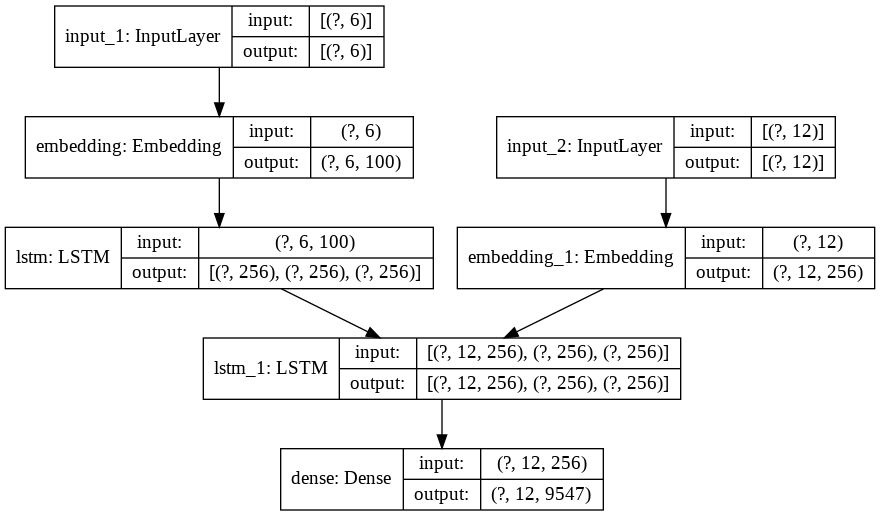

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [32]:
r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)

Epoch 1/40
572/572 [==============================] - 28s 49ms/step - loss: 2.1897 - accuracy: 0.7043 - val_loss: 2.2228 - val_accuracy: 0.6761
Epoch 2/40
572/572 [==============================] - 27s 48ms/step - loss: 1.5913 - accuracy: 0.7574 - val_loss: 1.9474 - val_accuracy: 0.7214
Epoch 3/40
572/572 [==============================] - 27s 48ms/step - loss: 1.3124 - accuracy: 0.7962 - val_loss: 1.7892 - val_accuracy: 0.7421
Epoch 4/40
572/572 [==============================] - 27s 47ms/step - loss: 1.1242 - accuracy: 0.8130 - val_loss: 1.7116 - val_accuracy: 0.7492
Epoch 5/40
572/572 [==============================] - 28s 48ms/step - loss: 0.9704 - accuracy: 0.8269 - val_loss: 1.6634 - val_accuracy: 0.7557
Epoch 6/40
572/572 [==============================] - 27s 47ms/step - loss: 0.8380 - accuracy: 0.8393 - val_loss: 1.6268 - val_accuracy: 0.7606
Epoch 7/40
572/572 [==============================] - 27s 47ms/step - loss: 0.7209 - accuracy: 0.8527 - val_loss: 1.6141 - val_accuracy:

**Improving the model for prediction**

In [33]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [34]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [35]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [36]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [37]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [38]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

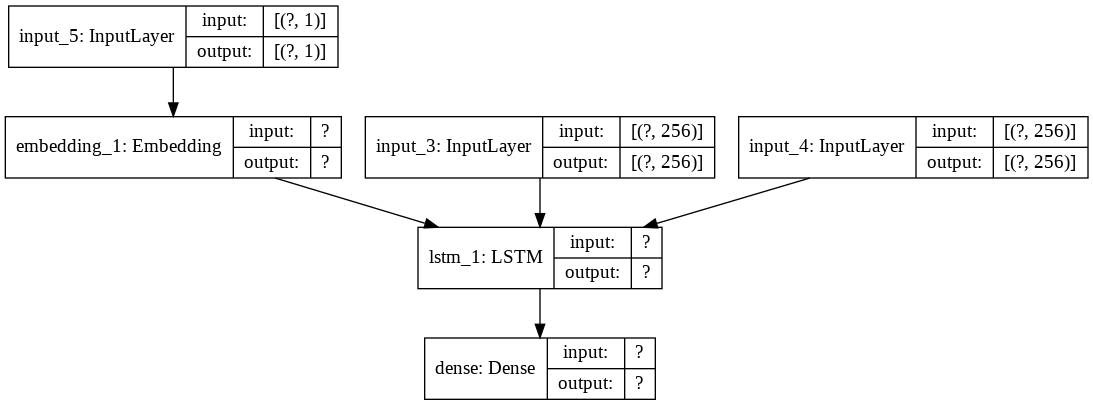

In [39]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [40]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [41]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [68]:
# Performing prediction
eng_words=[]
french_words=[]
scores=[]
for _ in tqdm(range(1000)):
  i = np.random.choice(len(input_sentences))
  input_seq = encoder_input_sequences[i:i+1]
  translation = translate_sentence(input_seq)
  eng_words.append(input_sentences[i])
  french_words.append(translation)
  #print('-')
  #print('Input:', input_sentences[i])
  #print('Output',output_sentences[i].split('<')[0])
  #print('Prediction:', translation)
  references =[output_sentences[i]]
  candidates = [translation]
  score = corpus_bleu(references, candidates)
  scores.append(score)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [69]:
# Average BLEU score on the testing data
from statistics import mean 
print(mean(scores))

0.8697922598387215


In [71]:
df=pd.DataFrame()

In [72]:
df['English_words']=eng_words
df['predicted_french_words']=french_words

In [74]:
df.to_csv('prediction_data.csv')